# U2 - Abdullah Barhoum (5041774) und Katharina Müller (5284090)

# Assignment 2: Convolution and Canny edge detection

## Exercise 2.1
Implement the convolution operation for 2-D images (i.e. no colors here, sorry). 

In [2]:
#%matplotlib inline 
from skimage import io, color, filters
from matplotlib import pyplot as plt

def conv2d(image, kernel):
    # here goes your code
    
    result = image # remove this please
    return result

image = color.rgb2gray(io.imread('images/dog.jpg'))

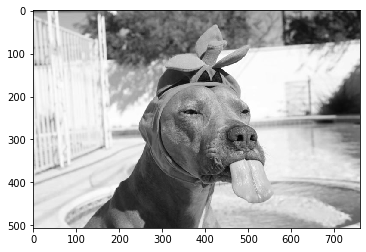

In [10]:
plt.imshow(conv2d(image, []), cmap='gray')

Convolve an image of your choice with a Gaussian kernel. Play around with the size of the kernel and the standard deviation of the Gaussian. Show your results (***RESULT***). 

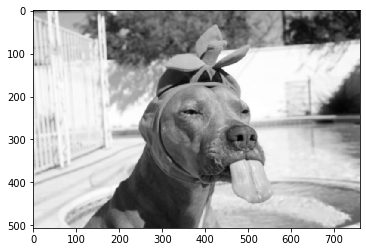

In [9]:
#default Gaussian 
plt.imshow(filters. gaussian(image), cmap='gray')

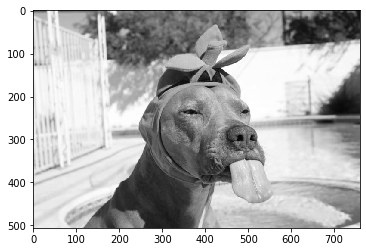

In [13]:
#small SD => less smoothing/blurring
plt.imshow(filters. gaussian(image, sigma=0.4), cmap='gray')

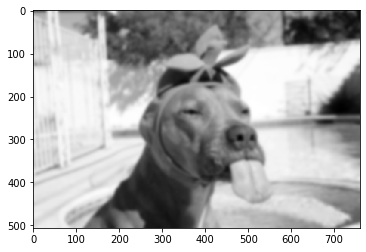

In [15]:
#large SD => more smoothing/blurring
plt.imshow(filters. gaussian(image, sigma=3), cmap='gray')

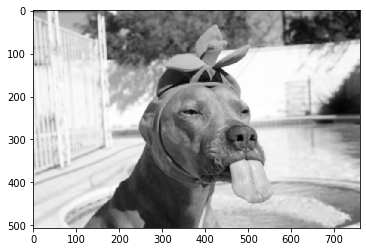

In [25]:
import numpy as np
import cv2
blur = cv2.GaussianBlur(image,(5,5),0)
plt.imshow(blur, cmap='gray')

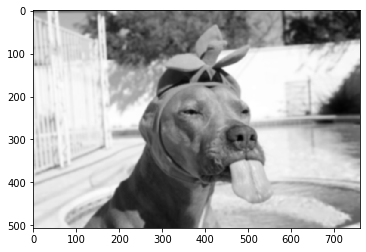

In [84]:
#big kernel => more blur
blur_2 = cv2.GaussianBlur(image,(9,9),0)
plt.imshow(blur2, cmap='gray')

Now, implement a simple edge detector by first filtering with a Sobel operator and then thresholding the ***RESULT***. How does smoothing the input change the ***RESULT***?

In [127]:
G_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 2]])
G_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

In [72]:
def edge_detector (image, kernel, show=False):    
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape
    result = np.zeros(image.shape)
    pad_h = int((kernel_h - 1) / 2)
    pad_w = int((kernel_w - 1) / 2)
    padded = np.zeros((image_h + (2 * pad_h),image_w + (2 * pad_w)))
    padded[pad_h:padded.shape[0] - pad_h, pad_w:padded.shape[1] - pad_w] = image
    
    for row in range(image_h):
        for col in range(image_w):
            result[row,col] = np.sum(kernel * padded[row:row + kernel_h, col:col + kernel_w])              
    return result

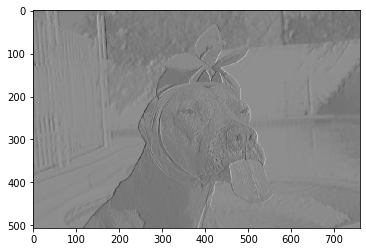

In [128]:
copy_1 = image
result_x = edge_detector(copy_1, G_x, True)
plt.imshow(result_x, cmap='gray')
plt.show()

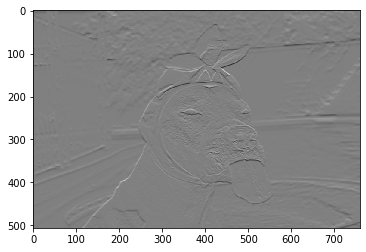

In [129]:
copy_2 = image
result_y = edge_detector(copy_2, G_y, True)
plt.imshow(result_y, cmap='gray')
plt.show()

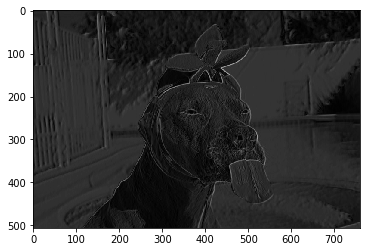

In [130]:
both = np.sqrt(np.square(result_x) + np.square(result_y))
both *= 255.0 / both.max()

plt.imshow(both, cmap='gray')
plt.show()

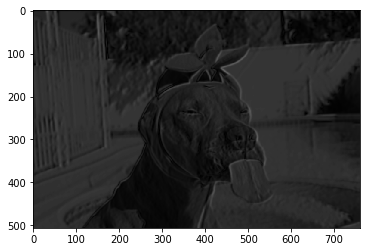

In [132]:
#more smoothing results in less clear edges
result_x_blur = edge_detector(blur_2, Gx, True)
result_y_blur = edge_detector(blur_2, Gy, True)
both_blur = np.sqrt(np.square(result_x_blur) + np.square(result_y_blur))
both_blur *= 255.0 / both_blur.max()
plt.imshow(both_blur, cmap='gray')
plt.show()

In [117]:
#Thresholding
def threshholding_function (image, threshold):
    image_h, image_w = image.shape
    plt.imshow(image, cmap='gray')
    plt.show()
    result = np.zeros(image.shape)
    for row in range(image_h):
        for col in range(image_w):
            if image[row,col] > threshold:
                result[row,col] = 0
            else:
                result[row,col] = 255
    return result

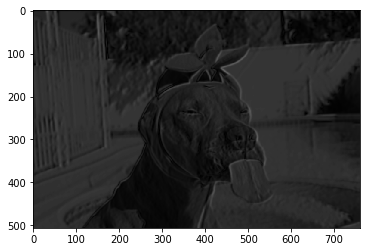

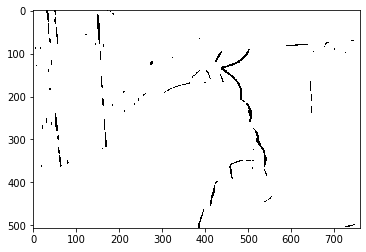

In [133]:
plt.imshow(threshholding_function(both_blur, 60), cmap='gray')
plt.show()

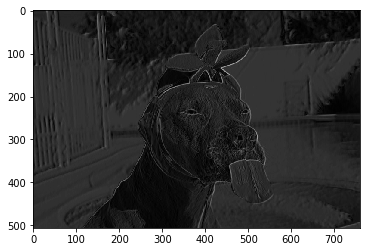

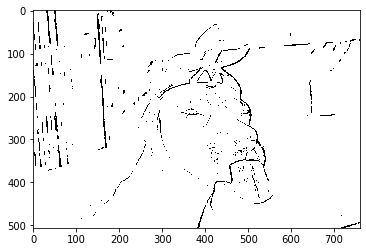

In [134]:
plt.imshow(threshholding_function(both, 60), cmap='gray')
plt.show()

## Exercise 1.2 Canny Edge Detection

### Preprocessing
If you haven't yet: smooth the image with a Gaussian of your choice. Then use the Sobel operator to create the gradient magnitude and direction matrices (see slides page 23). Round the gradient directions to the 8-neighbor's directions. Display all  intermediate ***RESULT***s!


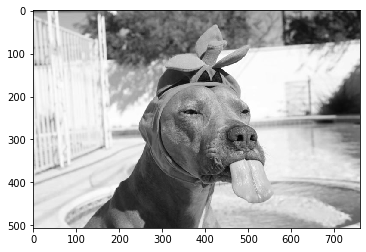

### Non-Maximum Suppression
Implement the Non-Maximum Suppression step as described in the lecture. Subtract the result from the gradient magnitude image and show the ***RESULT***!

### Thresholding and Edge Tracing
Implement the edge tracing as described in the lecture and show the final result for three different threshold pairs: two low thresholds (e.g. 20 and 50), high thresholds (e.g. 80 and 120) and thresholds with large spacing (e.g. 40 and 140). (***RESULT***)
